<a href="https://colab.research.google.com/github/BilalKhaliqWillis/BILAL-Assignment2/blob/main/BILAL_Assignment14.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import fairlearn.metrics as fl_metrics
from fairlearn.metrics import MetricFrame
import shap
import lime
import lime.lime_tabular
from sklearn.inspection import permutation_importance
import warnings
warnings.filterwarnings('ignore')

print("All libraries imported successfully!")

All libraries imported successfully!


In [7]:
# 1. DATASET PREPARATION

print("=" * 50)
print("1. DATASET PREPARATION")
print("=" * 50)

# Load the Adult Census Income Dataset (commonly used for fairness analysis)
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data"
column_names = [
    'age', 'workclass', 'fnlwgt', 'education', 'education-num',
    'marital-status', 'occupation', 'relationship', 'race', 'sex',
    'capital-gain', 'capital-loss', 'hours-per-week', 'native-country', 'income'
]

# Load dataset
df = pd.read_csv(url, names=column_names, na_values=' ?', skipinitialspace=True)

print(f"Dataset shape: {df.shape}")
print("\nFirst few rows:")
print(df.head())

1. DATASET PREPARATION
Dataset shape: (32561, 15)

First few rows:
   age         workclass  fnlwgt  education  education-num  \
0   39         State-gov   77516  Bachelors             13   
1   50  Self-emp-not-inc   83311  Bachelors             13   
2   38           Private  215646    HS-grad              9   
3   53           Private  234721       11th              7   
4   28           Private  338409  Bachelors             13   

       marital-status         occupation   relationship   race     sex  \
0       Never-married       Adm-clerical  Not-in-family  White    Male   
1  Married-civ-spouse    Exec-managerial        Husband  White    Male   
2            Divorced  Handlers-cleaners  Not-in-family  White    Male   
3  Married-civ-spouse  Handlers-cleaners        Husband  Black    Male   
4  Married-civ-spouse     Prof-specialty           Wife  Black  Female   

   capital-gain  capital-loss  hours-per-week native-country income  
0          2174             0              40

In [10]:
# Data preprocessing
print("\nData preprocessing...")

# Handle missing values
print(f"Missing values before cleaning: {df.isnull().sum().sum()}")
df = df.dropna()
print(f"Missing values after cleaning: {df.isnull().sum().sum()}")

# Preprocess target variable
df['income'] = df['income'].apply(lambda x: 1 if x.strip() == '>50K' else 0)

# Select features and target
features = ['age', 'education-num', 'hours-per-week', 'capital-gain', 'capital-loss', 'sex', 'race']
X = df[features].copy()
y = df['income']



Data preprocessing...
Missing values before cleaning: 0
Missing values after cleaning: 0


In [11]:
# Identify sensitive attribute
sensitive_attribute = 'sex'  # Gender as sensitive attribute
print(f"\nSensitive attribute selected: {sensitive_attribute}")

# Preprocess categorical features
categorical_features = ['sex', 'race']
for col in categorical_features:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col])

# Display dataset info
print(f"\nProcessed dataset shape: {X.shape}")
print(f"Target distribution:\n{y.value_counts()}")
print(f"\nSensitive attribute distribution:\n{df[sensitive_attribute].value_counts()}")


Sensitive attribute selected: sex

Processed dataset shape: (32561, 7)
Target distribution:
income
0    24720
1     7841
Name: count, dtype: int64

Sensitive attribute distribution:
sex
Male      21790
Female    10771
Name: count, dtype: int64


In [12]:
# 2. MODEL TRAINING AND EVALUATION

print("\n" + "=" * 50)
print("2. MODEL TRAINING AND EVALUATION")
print("=" * 50)

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# Scale numerical features
scaler = StandardScaler()
numerical_features = ['age', 'education-num', 'hours-per-week', 'capital-gain', 'capital-loss']
X_train[numerical_features] = scaler.fit_transform(X_train[numerical_features])
X_test[numerical_features] = scaler.transform(X_test[numerical_features])

print(f"Training set size: {X_train.shape}")
print(f"Test set size: {X_test.shape}")


2. MODEL TRAINING AND EVALUATION
Training set size: (22792, 7)
Test set size: (9769, 7)


In [13]:
# Train logistic regression model
model = LogisticRegression(random_state=42, max_iter=1000)
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]

# Evaluate model performance
accuracy = accuracy_score(y_test, y_pred)
print(f"\nModel Accuracy: {accuracy:.4f}")

print("\nConfusion Matrix:")
cm = confusion_matrix(y_test, y_pred)
print(cm)

print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Model Accuracy: 0.8243

Confusion Matrix:
[[7006  411]
 [1305 1047]]

Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.94      0.89      7417
           1       0.72      0.45      0.55      2352

    accuracy                           0.82      9769
   macro avg       0.78      0.69      0.72      9769
weighted avg       0.81      0.82      0.81      9769



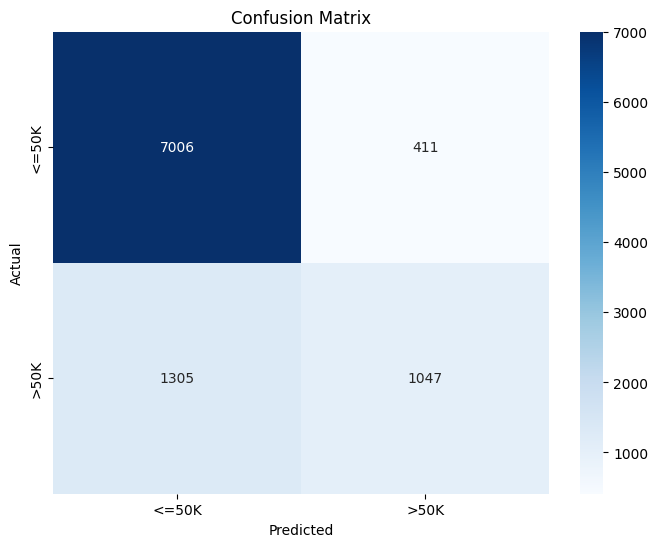

In [14]:
# Visualizing the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['<=50K', '>50K'],
            yticklabels=['<=50K', '>50K'])
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [15]:
# 3. FAIRNESS ANALYSIS

print("\n" + "=" * 50)
print("3. FAIRNESS ANALYSIS")
print("=" * 50)

# Preparing sensitive features for fairness analysis
sensitive_features_test = X_test[sensitive_attribute]

# Defining fairness metrics
def false_positive_rate(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return fp / (fp + tn)

def false_negative_rate(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return fn / (fn + tp)

def selection_rate(y_true, y_pred):
    return np.mean(y_pred)

# Creating MetricFrame for fairness analysis
metrics = {
    'accuracy': accuracy_score,
    'selection_rate': selection_rate,
    'false_positive_rate': false_positive_rate,
    'false_negative_rate': false_negative_rate,
    'true_positive_rate': fl_metrics.true_positive_rate,
    'true_negative_rate': fl_metrics.true_negative_rate
}

metric_frame = MetricFrame(
    metrics=metrics,
    y_true=y_test,
    y_pred=y_pred,
    sensitive_features=sensitive_features_test
)

print("Overall Metrics:")
print(metric_frame.overall)

print("\nMetrics by Group:")
print(metric_frame.by_group)


3. FAIRNESS ANALYSIS
Overall Metrics:
accuracy               0.824342
selection_rate         0.149248
false_positive_rate    0.055413
false_negative_rate    0.554847
true_positive_rate     0.445153
true_negative_rate     0.944587
dtype: float64

Metrics by Group:
     accuracy  selection_rate  false_positive_rate  false_negative_rate  \
sex                                                                       
0    0.909659        0.035324             0.007744             0.745810   
1    0.782801        0.204718             0.085009             0.520562   

     true_positive_rate  true_negative_rate  
sex                                          
0              0.254190            0.992256  
1              0.479438            0.914991  


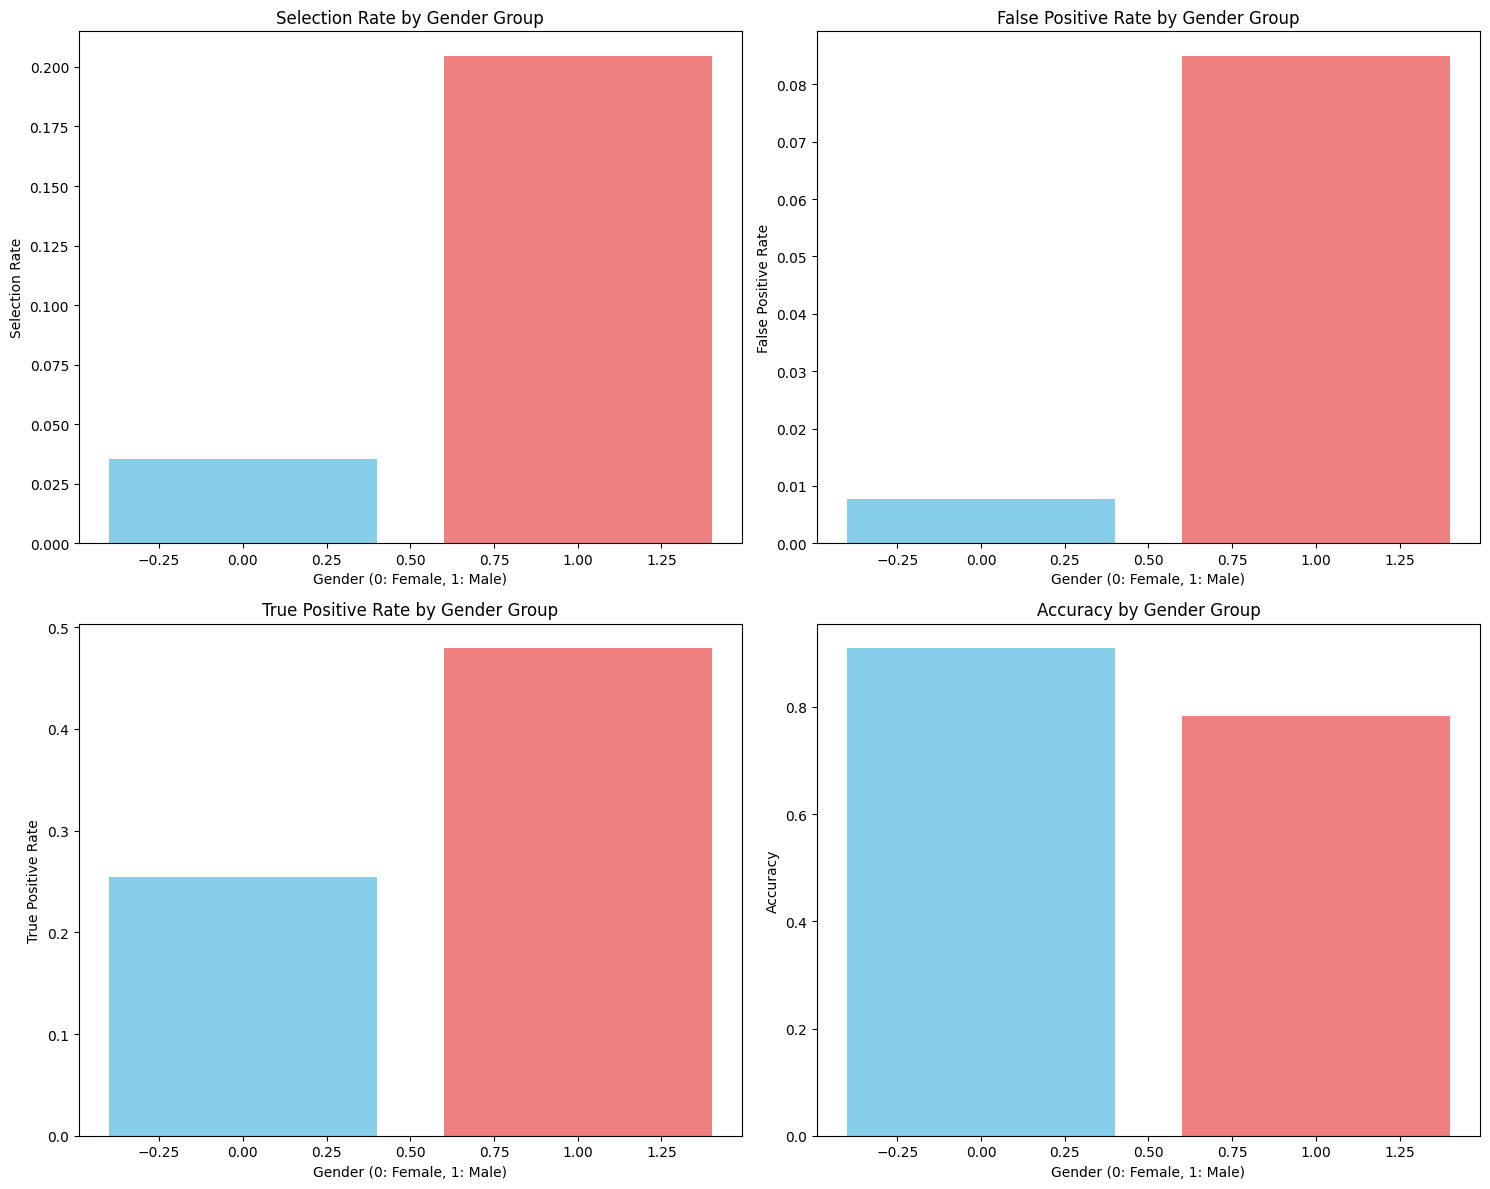


Fairness Disparity Analysis:
selection_rate disparity: 0.1694
false_positive_rate disparity: 0.0773
true_positive_rate disparity: 0.2252


In [16]:
# Visualize fairness metrics
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Selection Rate
selection_rates = metric_frame.by_group['selection_rate']
axes[0, 0].bar(selection_rates.index, selection_rates.values, color=['skyblue', 'lightcoral'])
axes[0, 0].set_title('Selection Rate by Gender Group')
axes[0, 0].set_ylabel('Selection Rate')
axes[0, 0].set_xlabel('Gender (0: Female, 1: Male)')

# False Positive Rate
fpr_rates = metric_frame.by_group['false_positive_rate']
axes[0, 1].bar(fpr_rates.index, fpr_rates.values, color=['skyblue', 'lightcoral'])
axes[0, 1].set_title('False Positive Rate by Gender Group')
axes[0, 1].set_ylabel('False Positive Rate')
axes[0, 1].set_xlabel('Gender (0: Female, 1: Male)')

# True Positive Rate
tpr_rates = metric_frame.by_group['true_positive_rate']
axes[1, 0].bar(tpr_rates.index, tpr_rates.values, color=['skyblue', 'lightcoral'])
axes[1, 0].set_title('True Positive Rate by Gender Group')
axes[1, 0].set_ylabel('True Positive Rate')
axes[1, 0].set_xlabel('Gender (0: Female, 1: Male)')

# Accuracy
accuracy_rates = metric_frame.by_group['accuracy']
axes[1, 1].bar(accuracy_rates.index, accuracy_rates.values, color=['skyblue', 'lightcoral'])
axes[1, 1].set_title('Accuracy by Gender Group')
axes[1, 1].set_ylabel('Accuracy')
axes[1, 1].set_xlabel('Gender (0: Female, 1: Male)')

plt.tight_layout()
plt.show()

# Calculating disparity
print("\nFairness Disparity Analysis:")
for metric in ['selection_rate', 'false_positive_rate', 'true_positive_rate']:
    group_metrics = metric_frame.by_group[metric]
    disparity = group_metrics.max() - group_metrics.min()
    print(f"{metric} disparity: {disparity:.4f}")


4. EXPLAINABILITY ANALYSIS
4.1 SHAP Analysis
SHAP values computed successfully!

Generating SHAP Summary Plot...


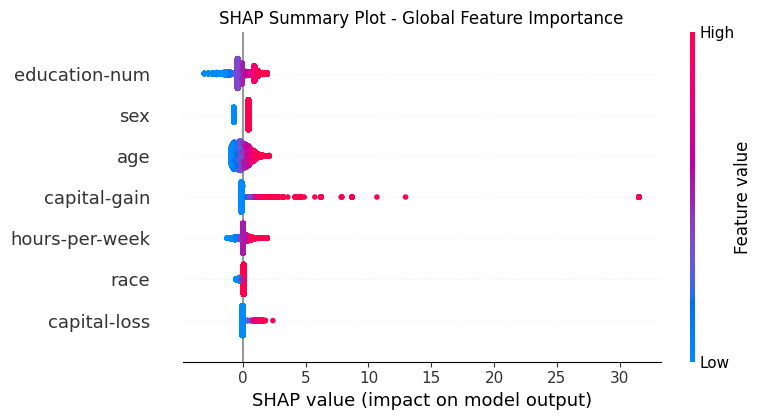

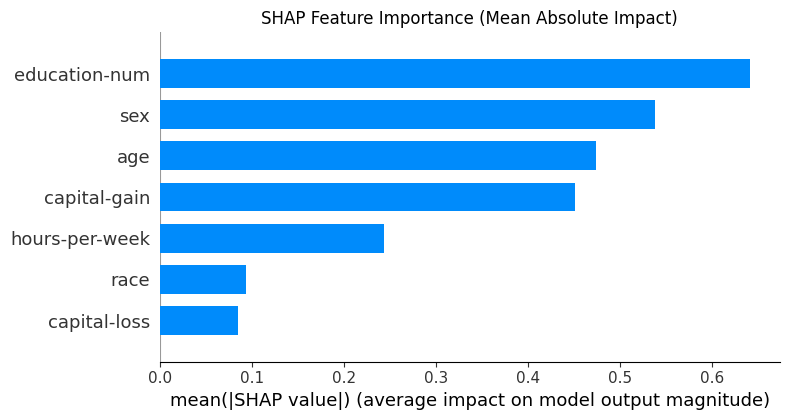


Generating SHAP Waterfall Plots for individual predictions...

--- SHAP Explanation for Instance 0 ---
Actual class: 1, Predicted class: 0
Prediction probability for >50K: 0.2233


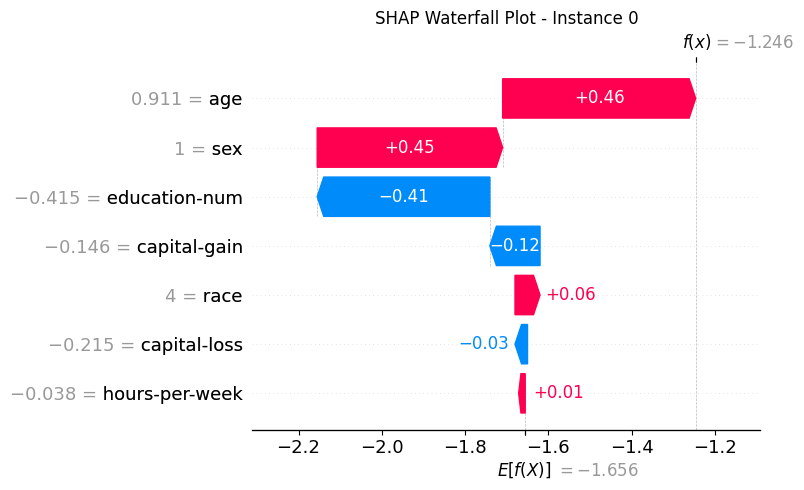


--- SHAP Explanation for Instance 10 ---
Actual class: 0, Predicted class: 0
Prediction probability for >50K: 0.1069


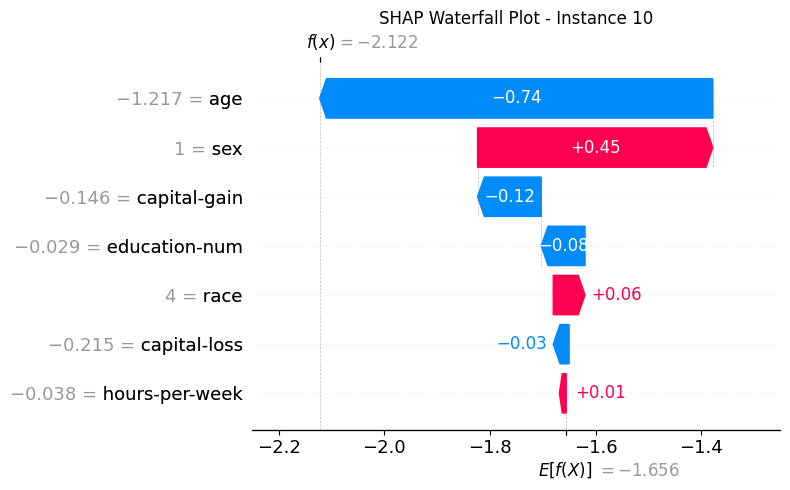


--- SHAP Explanation for Instance 50 ---
Actual class: 0, Predicted class: 1
Prediction probability for >50K: 0.5063


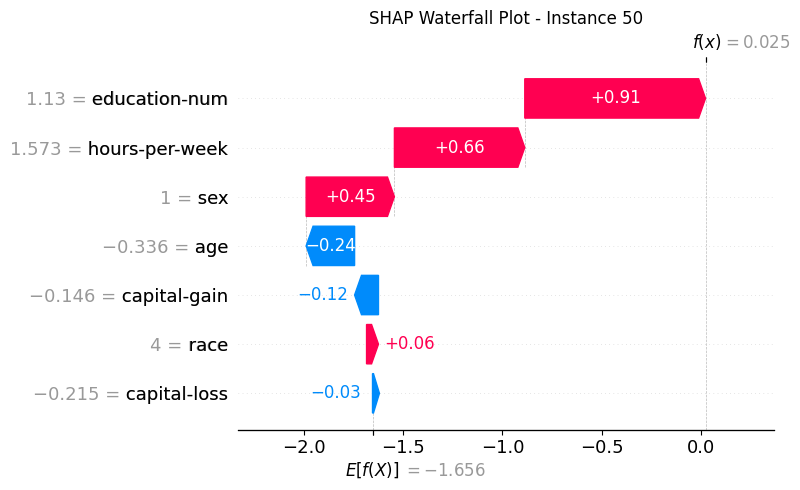

In [17]:
# 4. EXPLAINABILITY ANALYSIS

print("\n" + "=" * 50)
print("4. EXPLAINABILITY ANALYSIS")
print("=" * 50)

# 4.1 SHAP Analysis
print("4.1 SHAP Analysis")

# Initializing SHAP explainer
explainer = shap.LinearExplainer(model, X_train)
shap_values = explainer.shap_values(X_test)

print("SHAP values computed successfully!")

# Global SHAP summary plot
print("\nGenerating SHAP Summary Plot...")
plt.figure(figsize=(10, 8))
shap.summary_plot(shap_values, X_test, feature_names=features, show=False)
plt.title("SHAP Summary Plot - Global Feature Importance")
plt.tight_layout()
plt.show()

# SHAP bar plot for mean SHAP values
plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values, X_test, feature_names=features, plot_type="bar", show=False)
plt.title("SHAP Feature Importance (Mean Absolute Impact)")
plt.tight_layout()
plt.show()

# Local explanations with SHAP waterfall plots
print("\nGenerating SHAP Waterfall Plots for individual predictions...")

# Selecting a few instances for detailed explanation
sample_indices = [0, 10, 50]  # Different instances

for idx in sample_indices:
    print(f"\n--- SHAP Explanation for Instance {idx} ---")
    print(f"Actual class: {y_test.iloc[idx]}, Predicted class: {y_pred[idx]}")
    print(f"Prediction probability for >50K: {y_pred_proba[idx]:.4f}")

    plt.figure(figsize=(12, 6))
    shap.waterfall_plot(
        shap.Explanation(
            values=shap_values[idx],
            base_values=explainer.expected_value,
            data=X_test.iloc[idx],
            feature_names=features
        ),
        show=False
    )
    plt.title(f"SHAP Waterfall Plot - Instance {idx}")
    plt.tight_layout()
    plt.show()


4.2 LIME Analysis
LIME explainer initialized successfully!

--- LIME Explanation for Instance 0 ---
Actual: 1, Predicted: 0


<Figure size 1000x600 with 0 Axes>

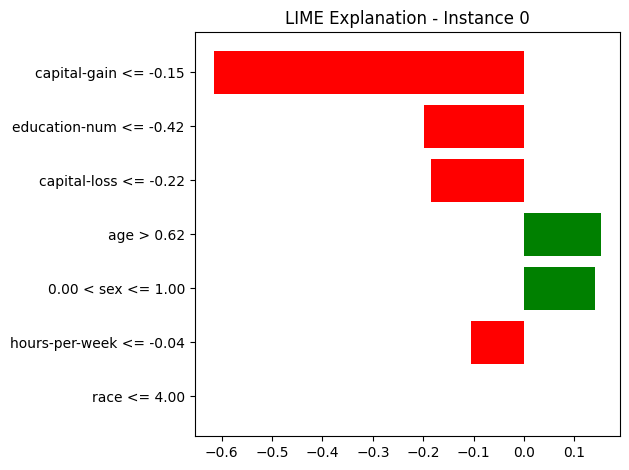


Detailed LIME Explanation:
[('capital-gain <= -0.15', -0.6150651104437331), ('education-num <= -0.42', -0.19881597379600469), ('capital-loss <= -0.22', -0.18413556395178693), ('age > 0.62', 0.1519191645245083), ('0.00 < sex <= 1.00', 0.14059735140178323), ('hours-per-week <= -0.04', -0.10433052496623074), ('race <= 4.00', 0.0)]

--- LIME Explanation for Instance 10 ---
Actual: 0, Predicted: 0


<Figure size 1000x600 with 0 Axes>

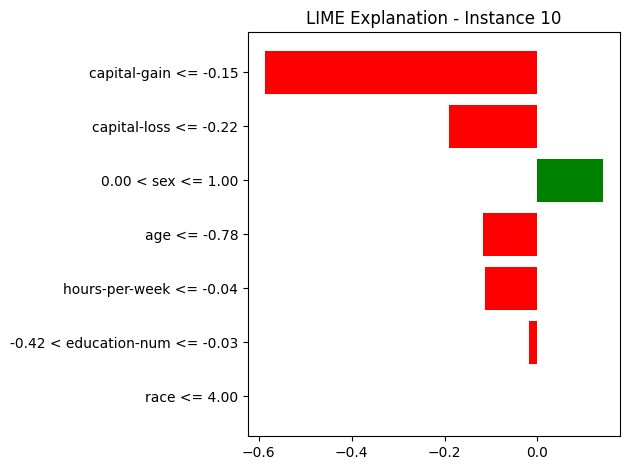


Detailed LIME Explanation:
[('capital-gain <= -0.15', -0.5868457310419557), ('capital-loss <= -0.22', -0.1904562499677959), ('0.00 < sex <= 1.00', 0.1414994539886031), ('age <= -0.78', -0.11679535432235734), ('hours-per-week <= -0.04', -0.11269782595126242), ('-0.42 < education-num <= -0.03', -0.018480358248405923), ('race <= 4.00', 0.0)]

--- LIME Explanation for Instance 50 ---
Actual: 0, Predicted: 1


<Figure size 1000x600 with 0 Axes>

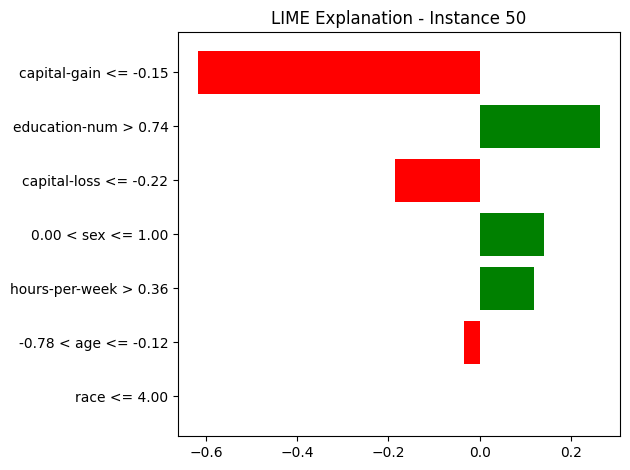


Detailed LIME Explanation:
[('capital-gain <= -0.15', -0.6169588051899985), ('education-num > 0.74', 0.26379126872605085), ('capital-loss <= -0.22', -0.1866828644745498), ('0.00 < sex <= 1.00', 0.14012911116228868), ('hours-per-week > 0.36', 0.11813325865231808), ('-0.78 < age <= -0.12', -0.03460033247811757), ('race <= 4.00', 0.0)]


In [18]:
# 4.2 LIME Analysis
print("\n4.2 LIME Analysis")

# Initializing LIME explainer
lime_explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=X_train.values,
    feature_names=features,
    class_names=['Income <=50K', 'Income >50K'],
    mode='classification',
    random_state=42
)

print("LIME explainer initialized successfully!")

# Generating LIME explanations for the same instances
for idx in sample_indices:
    print(f"\n--- LIME Explanation for Instance {idx} ---")
    print(f"Actual: {y_test.iloc[idx]}, Predicted: {y_pred[idx]}")

    # Getting LIME explanation
    exp = lime_explainer.explain_instance(
        X_test.iloc[idx].values,
        model.predict_proba,
        num_features=len(features)
    )

    # Plotting LIME explanation
    plt.figure(figsize=(10, 6))
    exp.as_pyplot_figure()
    plt.title(f"LIME Explanation - Instance {idx}")
    plt.tight_layout()
    plt.show()

    # Print detailed explanation
    print("\nDetailed LIME Explanation:")
    print(exp.as_list())


5. COMPREHENSIVE FAIRNESS VISUALIZATION


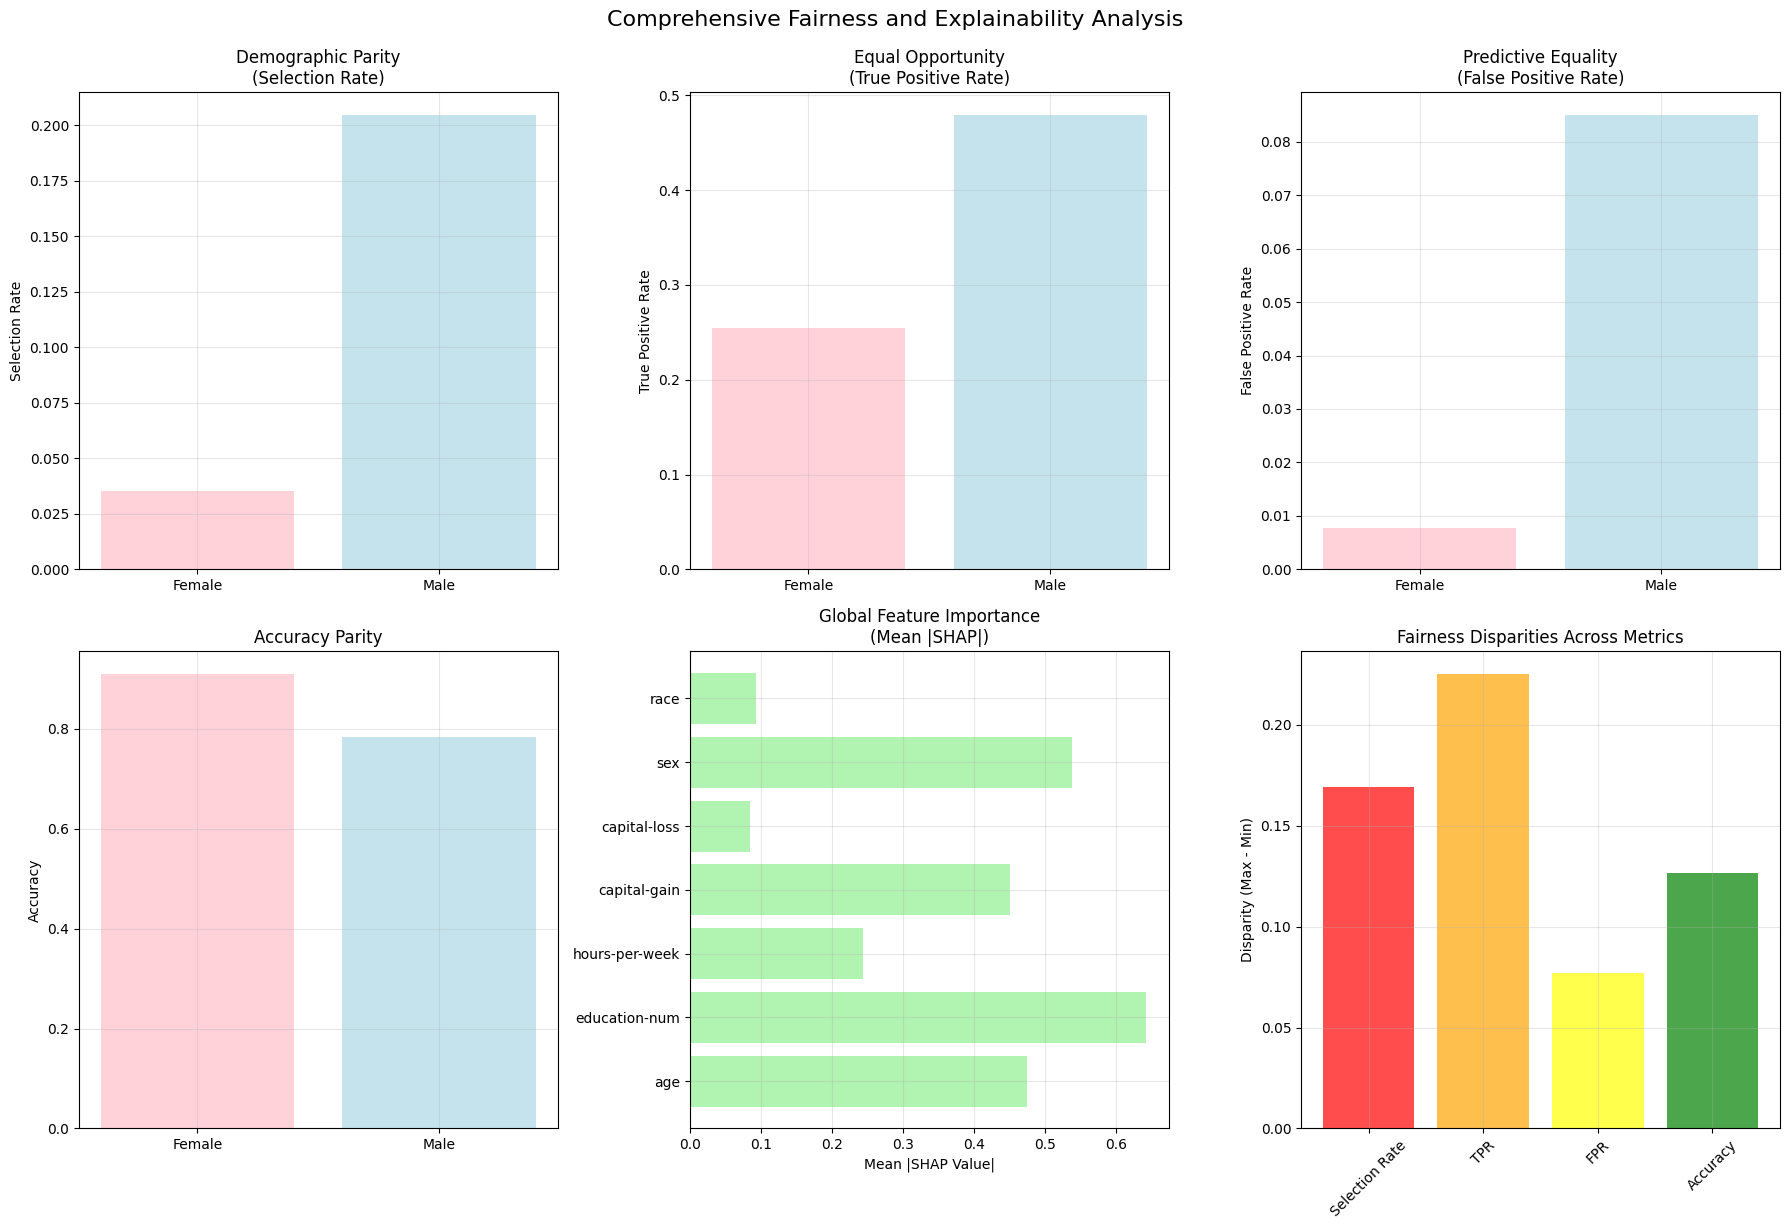


KEY FINDINGS SUMMARY

1. MODEL PERFORMANCE:
   - Overall Accuracy: 0.8243
   - Baseline (Majority Class): 0.7592

2. FAIRNESS ASSESSMENT:
   - Selection Rate Disparity: 0.1694
   - TPR Disparity: 0.2252
   - FPR Disparity: 0.0773
   - Accuracy Disparity: 0.1269

3. FEATURE IMPORTANCE (Top 3):
   - education-num: 0.6418
   - sex: 0.5375
   - age: 0.4742

4. SENSITIVE ATTRIBUTE ANALYSIS:
   - Female selection rate: 0.0353
   - Male selection rate: 0.2047
   - Ratio: 5.80

5. ETHICAL CONSIDERATIONS:
Significant demographic parity violation detected
Significant equal opportunity violation detected

ANALYSIS COMPLETE


In [22]:
# 5. COMPREHENSIVE FAIRNESS VISUALIZATION

print("\n" + "=" * 50)
print("5. COMPREHENSIVE FAIRNESS VISUALIZATION")
print("=" * 50)

# Creating a comprehensive fairness dashboard
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# 1. Demographic Parity
selection_rate_data = metric_frame.by_group['selection_rate']
axes[0, 0].bar(['Female', 'Male'], selection_rate_data.values,
               color=['pink', 'lightblue'], alpha=0.7)
axes[0, 0].set_title('Demographic Parity\n(Selection Rate)')
axes[0, 0].set_ylabel('Selection Rate')
axes[0, 0].grid(True, alpha=0.3)

# 2. Equal Opportunity
tpr_data = metric_frame.by_group['true_positive_rate']
axes[0, 1].bar(['Female', 'Male'], tpr_data.values,
               color=['pink', 'lightblue'], alpha=0.7)
axes[0, 1].set_title('Equal Opportunity\n(True Positive Rate)')
axes[0, 1].set_ylabel('True Positive Rate')
axes[0, 1].grid(True, alpha=0.3)

# 3. Predictive Equality
fpr_data = metric_frame.by_group['false_positive_rate']
axes[0, 2].bar(['Female', 'Male'], fpr_data.values,
               color=['pink', 'lightblue'], alpha=0.7)
axes[0, 2].set_title('Predictive Equality\n(False Positive Rate)')
axes[0, 2].set_ylabel('False Positive Rate')
axes[0, 2].grid(True, alpha=0.3)

# 4. Accuracy Parity
accuracy_data = metric_frame.by_group['accuracy']
axes[1, 0].bar(['Female', 'Male'], accuracy_data.values,
               color=['pink', 'lightblue'], alpha=0.7)
axes[1, 0].set_title('Accuracy Parity')
axes[1, 0].set_ylabel('Accuracy')
axes[1, 0].grid(True, alpha=0.3)

# 5. Feature Importance from SHAP
mean_abs_shap = np.abs(shap_values).mean(0)
axes[1, 1].barh(features, mean_abs_shap, color='lightgreen', alpha=0.7)
axes[1, 1].set_title('Global Feature Importance\n(Mean |SHAP|)')
axes[1, 1].set_xlabel('Mean |SHAP Value|')
axes[1, 1].grid(True, alpha=0.3)

# 6. Disparity Summary
disparities = {
    'Selection Rate': selection_rate_data.max() - selection_rate_data.min(),
    'TPR': tpr_data.max() - tpr_data.min(),
    'FPR': fpr_data.max() - fpr_data.min(),
    'Accuracy': accuracy_data.max() - accuracy_data.min()
}

axes[1, 2].bar(disparities.keys(), disparities.values(),
               color=['red', 'orange', 'yellow', 'green'], alpha=0.7)
axes[1, 2].set_title('Fairness Disparities Across Metrics')
axes[1, 2].set_ylabel('Disparity (Max - Min)')
axes[1, 2].tick_params(axis='x', rotation=45)
axes[1, 2].grid(True, alpha=0.3)

plt.tight_layout()
plt.suptitle('Comprehensive Fairness and Explainability Analysis',
             fontsize=16, y=1.02)
plt.show()

# Print key findings
print("\n" + "=" * 50)
print("KEY FINDINGS SUMMARY")
print("=" * 50)

print(f"\n1. MODEL PERFORMANCE:")
print(f"   - Overall Accuracy: {accuracy:.4f}")
print(f"   - Baseline (Majority Class): {max(y_test.value_counts(normalize=True)):.4f}")

print(f"\n2. FAIRNESS ASSESSMENT:")
for metric, disparity in disparities.items():
    print(f"   - {metric} Disparity: {disparity:.4f}")

print(f"\n3. FEATURE IMPORTANCE (Top 3):")
feature_importance_df = pd.DataFrame({
    'feature': features,
    'importance': mean_abs_shap
}).sort_values('importance', ascending=False)

for i, row in feature_importance_df.head(3).iterrows():
    print(f"   - {row['feature']}: {row['importance']:.4f}")

print(f"\n4. SENSITIVE ATTRIBUTE ANALYSIS:")
print(f"   - Female selection rate: {selection_rate_data[0]:.4f}")
print(f"   - Male selection rate: {selection_rate_data[1]:.4f}")
print(f"   - Ratio: {selection_rate_data[1]/selection_rate_data[0]:.2f}")

print("\n5. ETHICAL CONSIDERATIONS:")
if disparities['Selection Rate'] > 0.1:
    print("Significant demographic parity violation detected")
else:
    print("Demographic parity within acceptable limits")

if disparities['TPR'] > 0.1:
    print("Significant equal opportunity violation detected")
else:
    print("Equal opportunity within acceptable limits")

print("\n" + "=" * 50)
print("ANALYSIS COMPLETE")
print("=" * 50)